In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.3 MB/s eta 0:00:00


In [2]:
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_train.json -O KorQuAD_v1.0_train.json
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json -O KorQuAD_v1.0_dev.json

--2023-07-04 15:04:07--  https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
Resolving korquad.github.io (korquad.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38527475 (37M) [application/json]
Saving to: ‘KorQuAD_v1.0_train.json’

KorQuAD_v1.0_train. 100%[===================>]  36.74M   190MB/s    in 0.2s    

2023-07-04 15:04:08 (190 MB/s) - ‘KorQuAD_v1.0_train.json’ saved [38527475/38527475]

--2023-07-04 15:04:08--  https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json
Resolving korquad.github.io (korquad.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3881058 (3.7M) [application/json]
Saving to: ‘KorQuAD_v1.0_dev.json’

KorQuAD_v1.0_dev.js 100%[======

In [3]:
import os
import json
import numpy as np
from tqdm import tqdm
from pathlib import Path
from transformers import BertTokenizerFast
import tensorflow as tf

In [4]:
def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('KorQuAD_v1.0_train.json')
val_contexts, val_questions, val_answers = read_squad('KorQuAD_v1.0_dev.json')

In [5]:
print('훈련 데이터의 본문 개수 :', len(train_contexts))
print('훈련 데이터의 질문 개수 :', len(train_questions))
print('훈련 데이터의 답변 개수 :', len(train_answers))
print('테스트 데이터의 본문 개수 :', len(val_contexts))
print('테스트 데이터의 질문 개수 :', len(val_questions))
print('테스트 데이터의 답변 개수 :', len(val_answers))

훈련 데이터의 본문 개수 : 60407
훈련 데이터의 질문 개수 : 60407
훈련 데이터의 답변 개수 : 60407
테스트 데이터의 본문 개수 : 5774
테스트 데이터의 질문 개수 : 5774
테스트 데이터의 답변 개수 : 5774


In [8]:
print('첫번째 샘플의 본문')
print('-----------------')
print(train_contexts[5])

첫번째 샘플의 본문
-----------------
1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.


In [9]:
print('첫번째 샘플의 질문')
print('-----------------')
print(train_questions[0])

첫번째 샘플의 질문
-----------------
바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?


In [10]:
print('첫번째 샘플의 답변')
print('-----------------')
print(train_answers[0])

첫번째 샘플의 답변
-----------------
{'text': '교향곡', 'answer_start': 54}


In [11]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        answer['text'] = answer['text'].rstrip()
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        assert context[start_idx:end_idx] == gold_text, "end_index 계산에 에러가 있습니다."
        answer['answer_end'] = end_idx

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [12]:
print('첫번째 샘플의 답변')
print('-----------------')
print(train_answers[0])

첫번째 샘플의 답변
-----------------
{'text': '교향곡', 'answer_start': 54, 'answer_end': 57}


In [17]:
train_contexts[0]

'1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.'

In [18]:
train_contexts[0][55]

'향'

In [19]:
train_contexts[0][56]

'곡'

In [20]:
train_contexts[0][54:57]

'교향곡'

In [21]:
tokenizer = BertTokenizerFast.from_pretrained('klue/bert-base')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [22]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    deleting_list = []

    for i in tqdm(range(len(answers))):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
            deleting_list.append(i)

        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
            if i not in deleting_list:
              deleting_list.append(i)

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return deleting_list

In [30]:
len(train_answers)

60407

In [23]:
deleting_list_for_train = add_token_positions(train_encodings, train_answers)
deleting_list_for_test = add_token_positions(val_encodings, val_answers)

100%|██████████| 5774/5774 [00:00<00:00, 333786.94it/s]


In [24]:
def delete_samples(encodings, deleting_list):
  input_ids = np.delete(np.array(encodings['input_ids']), deleting_list, axis=0)
  attention_masks = np.delete(np.array(encodings['attention_mask']), deleting_list, axis=0)
  start_positions = np.delete(np.array(encodings['start_positions']), deleting_list, axis=0)
  end_positions = np.delete(np.array(encodings['end_positions']), deleting_list, axis=0)

  X_data = [input_ids, attention_masks]
  y_data = [start_positions, end_positions]

  return X_data, y_data

In [25]:
X_train, y_train = delete_samples(train_encodings, deleting_list_for_train)
X_test, y_test = delete_samples(val_encodings, deleting_list_for_test)

In [31]:
# TPU 작동을 위한 코드 TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [32]:
strategy = tf.distribute.TPUStrategy(resolver)

In [33]:
from transformers import TFBertModel

In [34]:
class TFBertForQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name):
        super(TFBertForQuestionAnswering, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.qa_outputs = tf.keras.layers.Dense(2,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                name='qa_outputs')
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)

        sequence_output = outputs[0]

        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = tf.split(logits, 2, axis=-1)

        # start_logits = (batch_size, sequence_length,)
        # end_logits = (batch_size, sequence_length,)
        start_logits = tf.squeeze(start_logits, axis=-1)
        end_logits = tf.squeeze(end_logits, axis=-1)

        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)

        return start_probs, end_probs

In [35]:
# 신규
with strategy.scope():
  model = TFBertForQuestionAnswering("klue/bert-base")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
  model.compile(optimizer=optimizer, loss=loss)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [36]:
history = model.fit(
    X_train,
    y_train,
    epochs=3,
    verbose=1,
    batch_size=16,
)

Epoch 1/3


3759/3759 [==============================] - 498s 111ms/step - loss: 1.1344 - output_1_loss: 0.5092 - output_2_loss: 0.6252
Epoch 2/3
3759/3759 [==============================] - 412s 110ms/step - loss: 0.6320 - output_1_loss: 0.2691 - output_2_loss: 0.3629
Epoch 3/3
3759/3759 [==============================] - 411s 109ms/step - loss: 0.4496 - output_1_loss: 0.1854 - output_2_loss: 0.2642


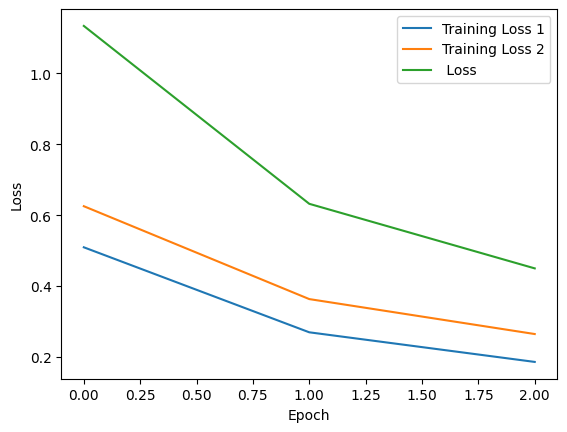

In [61]:
import matplotlib.pyplot as plt

# Train the model and collect the training history

# Plot the training and validation loss
plt.plot(history.history['output_1_loss'], label='Training Loss 1')
plt.plot(history.history['output_2_loss'], label='Training Loss 2')
plt.plot(history.history['loss'], label=' Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [59]:
history.history['loss']

[0.5091648101806641, 0.26907646656036377, 0.1854310929775238]

In [54]:
(tokenizer.decode(X_test[0][1]).split('[SEP] '))[1]

'1989년 6월 30일 평양축전에 대표로 파견 된 인물은? '

In [63]:
def predict_test_data_by_idx(idx):
  context = tokenizer.decode(X_test[0][idx]).split('[SEP] ')[0]
  question = tokenizer.decode(X_test[0][idx]).split('[SEP] ')[1]
  print('main text :', context)
  print('question :', question)
  answer_encoded = X_test[0][idx][y_test[0][idx]:y_test[1][idx]+1]
  print('answer :',tokenizer.decode(answer_encoded))
  output = model([tf.constant(X_test[0][idx])[None, :], tf.constant(X_test[1][idx])[None, :]])
  start = tf.math.argmax(tf.squeeze(output[0]))
  end = tf.math.argmax(tf.squeeze(output[1]))+1
  answer_encoded = X_test[0][idx][start:end]
  print('prediction :',tokenizer.decode(answer_encoded))
  print('----------------------------------------')

In [64]:
for i in range(0, 100):
  predict_test_data_by_idx(i)

main text : [CLS] 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의 ( 폭력행위등처벌에관한법률위반 ) 으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일 ~ 20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다. 
question : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은? 
answer : 1989년 2월 15일
prediction : 1989년 2월 15일
----------------------------------------
main text : [CLS] 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의 ( 폭력행위등처벌에관한법률위반 ) 으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일 ~ 20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 